<a href="https://colab.research.google.com/github/mneunhoe/ds3_gan/blob/main/02_ds3_gan_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{DS}^3$: Generative Adversarial Nets
(Marcel Neunhoeffer, LMU Munich)

This is the second workbook for the Data Science Summer School course "Generative Adversarial Nets". 

You can find the slides and the following workbooks for this course at: https://github.com/mneunhoe/ds3_gan


In this workbook we will implement a Generative Adversarial Net to generate fake images.



Before we get started, we install and load some helpful packages to our R environment. Installing `torch` can take some time (around 6 minutes for me). For this tutorial to work you should choose a GPU runtime.

In [1]:
p_needed <- c("torch", "RGAN", "torchvision", "here")
packages <- rownames(installed.packages())
p_to_install <- p_needed[!(p_needed %in% packages)]
if (length(p_to_install) > 0) {
  install.packages(p_to_install)
}
sapply(p_needed, require, character.only = TRUE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘Rcpp’, ‘coro’, ‘viridis’, ‘jpeg’, ‘png’, ‘abind’


Loading required package: torch

Loading required package: RGAN

Loading required package: torchvision

Loading required package: here

here() starts at /content



torch        RGAN torchvision        here 
       TRUE        TRUE        TRUE        TRUE

## A GAN to generate fake images


### Downloading and setting up the training data

In this example we will work with the celeba dataset.

In [3]:
if(!dir.exists(here::here("celeba/img_align_celeba"))){
# Create celeba directory in working directory
dir.create(here::here("celeba"))

# Download the celeba images
invisible(system(
  paste0(
    "wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip -O",
    here::here("celeba/img_align_celeba.zip")
  ),
  intern = TRUE
))

# Unzip the folder
invisible(system(paste0(
  "unzip -o ",
  here::here("celeba/img_align_celeba.zip"),
  " -d ",
  here::here("celeba")
), intern = TRUE))
}

### Image preprocessing and setting up the neural networks
In this example we will use the so called DCGAN (Deep Convolutional GAN) architecture. Since we are working with images now, this makes sense. The GAN expects that all pictures have the same size, therefore, we need to preprocess the pictures while loading a batch of images. Here we make sure that every picture is of size 64x64.

If a GPU is available we would like to train on it as this significantly speeds up training.

In [13]:
torch::torch_manual_seed(20220803)
dataset <- torchvision::image_folder_dataset(root = here::here("celeba"),
                                             transform = function(x) {
                                               x = torchvision::transform_to_tensor(x)
                                               x = torchvision::transform_resize(x, size = c(64, 64))
                                               x = torchvision::transform_center_crop(x, c(64, 64))
                                               x = torchvision::transform_normalize(x, c(0.5, 0.5, 0.5), 
                                                                                    c(0.5, 0.5, 0.5))
                                               return(x)
                                             })

device <- torch::torch_device(ifelse(torch::cuda_is_available(), "cuda", "cpu"))

g_net <- RGAN::DCGAN_Generator(dropout_rate = 0, noise_dim = 100)$to(device = device)
d_net <- RGAN::DCGAN_Discriminator(dropout_rate = 0, sigmoid = F)$to(device = device)


g_optim <- torch::optim_adam(g_net$parameters, lr = 0.0002, betas = c(0.5, 0.999))
d_optim <- torch::optim_adam(d_net$parameters, lr = 0.0002, betas = c(0.5, 0.999))

noise_dim <- c(100, 1, 1)
fixed_z <-
  torch::torch_randn(c(16, noise_dim))$to(device = device)

In [10]:
trained_gan <- RGAN::gan_trainer(
  data = dataset,
  noise_dim = noise_dim,
  noise_distribution = "normal",
  data_type = "image",
  value_function = "wasserstein",
  generator = g_net,
  generator_optimizer = g_optim,
  discriminator = d_net,
  discriminator_optimizer = d_optim,
  plot_progress = FALSE,
  plot_interval = 10,
  batch_size = 128,
  synthetic_examples = 16,
  device = device,
  eval_dropout = FALSE,
  epochs = 1
)

Training the GAN ■                                  0% | ETA:  5h

Training the GAN ■                                  0% | ETA:  6h

Training the GAN ■                                  0% | ETA:  6h

Training the GAN ■                                  0% | ETA:  5h



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

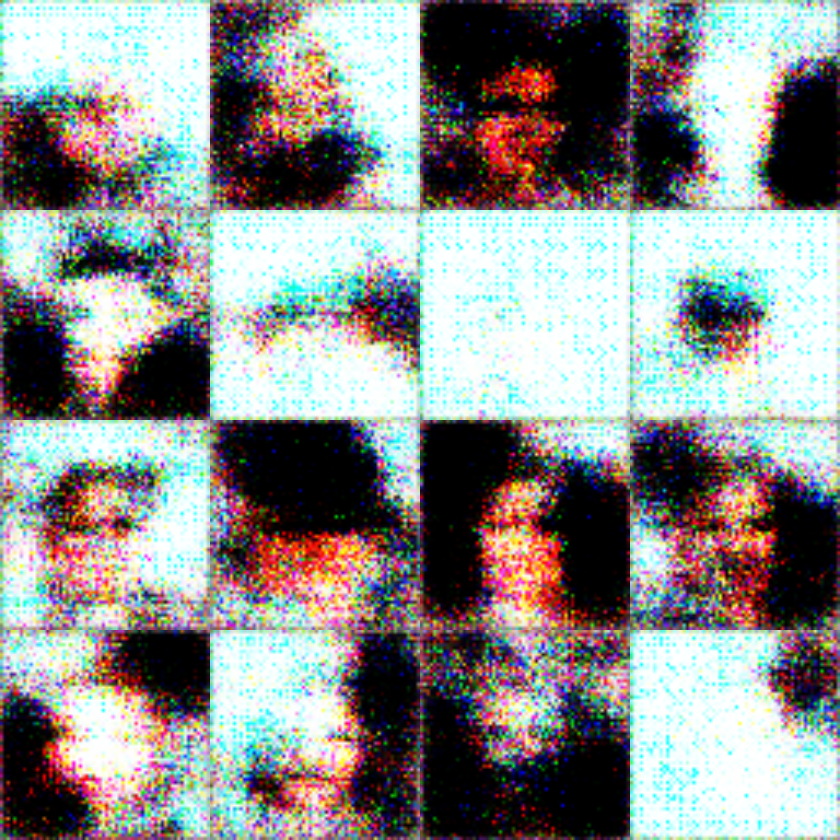

In [11]:
GAN_update_plot_image(synth_data = expert_sample_synthetic_data(g_net, fixed_z, device,eval_dropout = FALSE))